<>:10: SyntaxWarning: invalid escape sequence '\A'
<>:10: SyntaxWarning: invalid escape sequence '\A'
C:\Users\mdraf\AppData\Local\Temp\ipykernel_32008\3203664563.py:10: SyntaxWarning: invalid escape sequence '\A'
  AUDIO_FILE_PATH = "B:\AAUB 22024010 7th\AVE 4701\Lab\Audio Fingerprinting\Dataset\ONE_OK_ROCK_SAVE_YOURSELF_OFFICIAL_VIDEO_Fueled_By_Ramen.wav"


Successfully loaded file. Sampling Rate (sr): 10000.0 Hz
Note: Converted stereo audio to mono (left channel).
Signal length: 1979760 samples


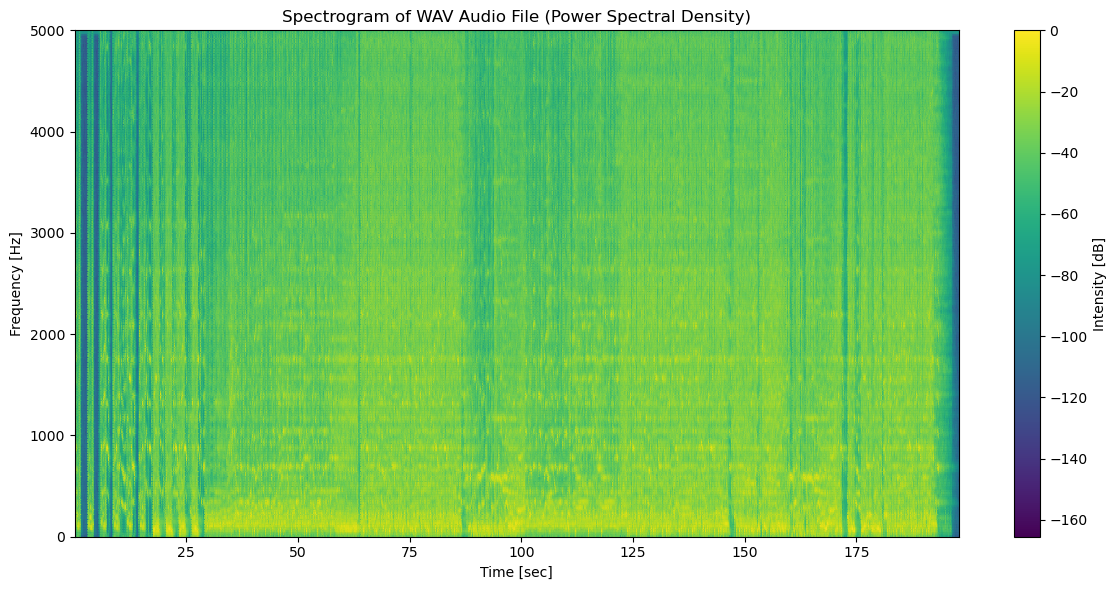

In [13]:
import numpy as np
from scipy.io import wavfile
from scipy import signal
import matplotlib.pyplot as plt
import librosa
from scipy.signal import resample

# --- 1. Audio Loading (Input File) ---
# NOTE: Replace 'your_audio_file.wav' with the actual path to your WAV file.
AUDIO_FILE_PATH = "B:\AAUB 22024010 7th\AVE 4701\Lab\Audio Fingerprinting\Dataset\ONE_OK_ROCK_SAVE_YOURSELF_OFFICIAL_VIDEO_Fueled_By_Ramen.wav"

try:
    # Read the WAV file:
    # sr: Sampling rate (e.g., 44100 Hz)
    # data: Audio signal data (a NumPy array)
    sr, data = wavfile.read(AUDIO_FILE_PATH)

    tar_sr = 10e3
    num_tar_sample = int(len(data)*tar_sr/sr)
    data = resample(data, num_tar_sample)
    sr= tar_sr

    print(f"Successfully loaded file. Sampling Rate (sr): {sr} Hz")
    
    # If the audio is stereo (2 channels), use only the first channel (mono)
    if data.ndim > 1:
        y = data[:, 0]  # Take the left channel
        print("Note: Converted stereo audio to mono (left channel).")
    else:
        y = data

    
    print(f"Signal length: {y.shape[0]} samples")


except FileNotFoundError:
    print(f"Error: WAV file not found at {AUDIO_FILE_PATH}")
    exit()
except Exception as e:
    print(f"Error reading WAV file: {e}")
    exit()


nperseg_val = int(sr * 0.04)   # Segment length (e.g., 40ms)
noverlap_val = int(sr * 0.02)  # Overlap length (e.g., 20ms)


f, t_spec, Sxx = signal.spectrogram(
    y,
    fs=sr,
    window='hann',
    nperseg=nperseg_val,
    noverlap=noverlap_val,
    scaling='density'
)

Sxx = Sxx/np.max(Sxx)  # Normalize Sxx to [0, 1]

Sxx_db = 10 * np.log10(Sxx, out=np.full_like(Sxx, -100.0), where=Sxx>0)

plt.figure(figsize=(12, 6))


plt.pcolormesh(t_spec, f, Sxx_db, shading='gouraud', cmap='viridis')

plt.title('Spectrogram of WAV Audio File (Power Spectral Density)')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='Intensity [dB]')
plt.ylim(0, sr / 2) # Show frequencies up to the Nyquist frequency
plt.tight_layout()
plt.show()

In [14]:
from scipy.ndimage import convolve1d

def cfar(data, guard_len = 10, train_len = 100, p_fa = 0.05, order='F'):
    r, c = data.shape
    data = data.flatten(order =order)
    a = train_len*(p_fa**(-1/train_len) - 1)
    cfar_kernel = np.ones((1 + 2*guard_len + 2*train_len), dtype=float) / (2*train_len)
    cfar_kernel[train_len: train_len + (2*guard_len) + 1] = 0.
    gaurd_cells = np.zeros_like(cfar_kernel)
    gaurd_cells[train_len: train_len + (2*guard_len) + 1] = cfar_kernel[0]
    gaurd_cells[len(gaurd_cells)//2] = 0.
    cut = np.zeros_like(cfar_kernel)
    cut[len(gaurd_cells)//2] = cfar_kernel[0]

    noise_level = convolve1d(data, cfar_kernel, mode='nearest')
    threshold = noise_level * a
    detected = data > threshold
    detected = detected.reshape(r, c, order='F')

    return detected


def detect_peaks(data, t_spec, f, slices = (10,30), selection_ratio=2e-4, plot=False):
    rows, cols = data.shape
    window_cols = cols//slices[1]
    window_rows = rows//slices[0]
    print(f"Window size: {window_rows} rows")
    print(f"Window size: {window_cols} columns")
    marker = np.zeros_like(data)
    for j in range(0, rows - window_rows, window_rows):

        for i in range(0, cols - window_cols, window_cols):
            window = data[j:j+window_rows, i:i + window_cols]
            k = int(window.size*selection_ratio)
            top_value_indexes = np.argpartition(window.flatten(), -k)[-k:]
            top_values = window.flatten()[top_value_indexes]
            non_zero_mask = top_values > 0
            top_value_indexes = top_value_indexes[non_zero_mask]
            r, c = np.unravel_index(top_value_indexes, window.shape)
            marker[r + j, c + i] = 1

    if plot:
        row_indices, col_indices = np.where(marker == 1)
        freq_coords = f[row_indices]
        time_coords = t_spec[col_indices]

        plt.figure(figsize=(12, 6))
        plt.pcolormesh(t_spec, f, data, shading='gouraud', cmap='gray')
        plt.scatter(time_coords, freq_coords, c='red', s=10)
        plt.title('Detected Peaks in Spectrogram')
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.ylim(0, sr / 2) # Show frequencies up to the Nyquist
        plt.tight_layout()
        plt.show()
        
    return marker

Cleaning spectogram using CFAR

Window size: 67 rows
Window size: 329 columns


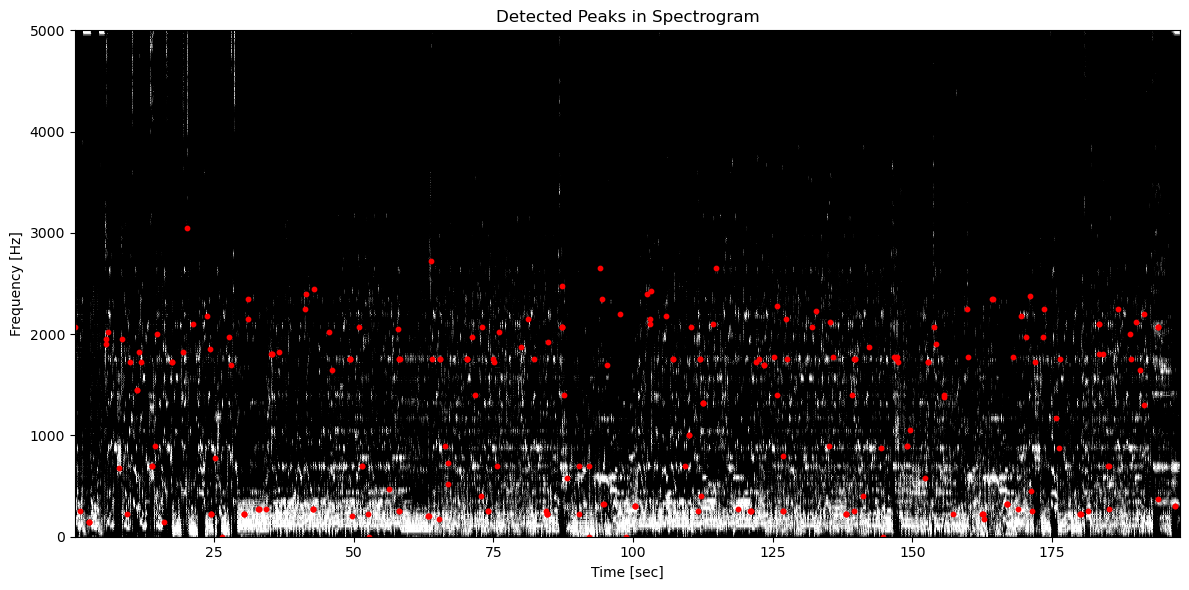

In [21]:
sxx_cfar = cfar(Sxx)
cfar_marker = detect_peaks(sxx_cfar, t_spec, f, slices=(3,30), selection_ratio=2e-4 ,plot=True)

Cleaning using averaging threshold

Window size: 67 rows
Window size: 329 columns


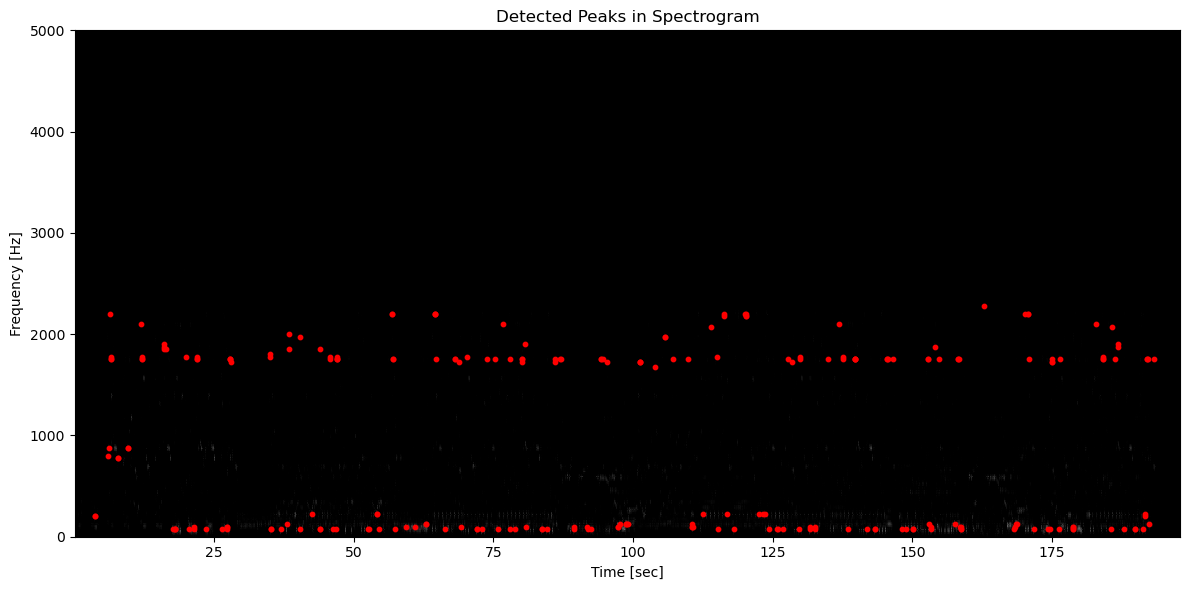

In [ ]:
threshold = np.average(np.sort(Sxx.flatten())[-int(Sxx.size*0.1)])  # Keep top 1000 values
Sxx_filtered = np.where(Sxx >= threshold, Sxx, 0)

avg_marker = detect_peaks(Sxx_filtered, t_spec, f, slices=(3,30), selection_ratio=2e-4, plot=True)